In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
sys.path.append('../src')

from mvt_brr import MVTModel

In [2]:
model = MVTModel(decay_type='exponential')

# rich_proportions = np.array([0.2, 0.3, 0.5])
# poor_proportions = np.array([0.5, 0.3, 0.2])

# avg_reward_rate_rich = model.get_average_reward_rate(rich_proportions)
# avg_reward_rate_poor = model.get_average_reward_rate(poor_proportions)
# print(avg_reward_rate_rich, avg_reward_rate_poor)

# MVT_rich, MVT_poor = model.run()
# print(MVT_rich, MVT_poor)

In [3]:
df_trials = pd.read_csv("../leheron_trialbytrial/leheron_trialbytrial.csv")
# print(df_trials[:50])
proportions = df_trials.groupby(['sub', 'env', 'patch']).size().unstack(fill_value=0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)
proportions

patch           1         2         3
sub env                              
1   1    0.250000  0.250000  0.500000
    2    0.466667  0.333333  0.200000
2   1    0.200000  0.314286  0.485714
    2    0.485714  0.314286  0.200000
3   1    0.185185  0.259259  0.555556
...           ...       ...       ...
37  2    0.500000  0.291667  0.208333
38  1    0.185185  0.259259  0.555556
    2    0.500000  0.307692  0.192308
39  1    0.217391  0.260870  0.521739
    2    0.521739  0.304348  0.173913

[78 rows x 3 columns]

In [81]:
# Function to get the average reward using calculated proportions for each subject and environment
def get_avg_rewards_per_subject_env(df_trials, proportions):
    avg_rewards = {}
    for sub in df_trials['sub'].unique():
        for env in df_trials['env'].unique():
            patch_proportions = proportions.loc[(sub, env)].values
            avg_reward = model.get_average_reward_rate(patch_proportions)
            avg_rewards[(sub, env)] = avg_reward
    return avg_rewards

avg_rewards = get_avg_rewards_per_subject_env(df_trials, proportions)

In [205]:
class Agent:
    def __init__(self, decay_rate_means, decay_rate_stds, observation_var=0.001):
        self.decay_rate_means = decay_rate_means
        self.decay_rate_stds = decay_rate_stds
        self.observation_var = observation_var
        self.beliefs = {i+1: {'mean': decay_rate_means[i], 'std': decay_rate_stds[i]} for i in range(len(decay_rate_means))}
        self.decay_rate_stds_history = {i+1: [] for i in range(len(decay_rate_means))}

    def sample_decay_rate(self, patch_type):
        belief = self.beliefs[patch_type]
        return np.random.normal(belief['mean'], belief['std'])

    def update_belief(self, patch_type, observed_decay_rate):
        belief = self.beliefs[patch_type]
        prior_mean = belief['mean']
        prior_var = belief['std'] ** 2
        observation_var = self.observation_var

        posterior_mean = (prior_var * observed_decay_rate + observation_var * prior_mean) / (prior_var + observation_var)
        posterior_var = (prior_var * observation_var) / (prior_var + observation_var)

        self.beliefs[patch_type]['mean'] = posterior_mean
        self.beliefs[patch_type]['std'] = np.sqrt(posterior_var)
        
        self.decay_rate_stds_history[patch_type].append(self.beliefs[patch_type]['std'])

    def decide_leave(self, reward, average_reward):
        return reward < average_reward

In [206]:
class Patch:
    def __init__(self, initial_yield, decay_rate, decay_type='exponential'):
        self.initial_yield = initial_yield
        self.decay_rate = decay_rate
        self.decay_type = decay_type
        self.time = 0
        self.harvesting = False

    def start_harvesting(self):
        self.harvesting = True
        self.time = 0

    def get_reward(self):
        if self.harvesting:
            if self.decay_type == 'exponential':
                reward = max(0, self.initial_yield * np.exp(-self.decay_rate * self.time))
            elif self.decay_type == 'linear':
                reward = max(0, self.initial_yield - self.decay_rate * self.time)
            else:
                raise ValueError("Invalid decay type. Use 'exponential' or 'linear'.")
            self.time += 1
            return reward
        else:
            return self.initial_yield

In [208]:
# Simulate using the derived proportions
class Simulation:
    def __init__(self, decay_rate_means, decay_rate_stds, avg_rewards):
        self.decay_rate_means = decay_rate_means
        self.decay_rate_stds = decay_rate_stds
        self.avg_rewards = avg_rewards
        self.patch_types = self.initialize_env()

    def initialize_env(self):
        patch_types = [
            {'type': 1, 'initial_yield': 32.5, 'decay_rate_mean': self.decay_rate_means[0], 'decay_rate_std': self.decay_rate_stds[0]},
            {'type': 2, 'initial_yield': 45, 'decay_rate_mean': self.decay_rate_means[1], 'decay_rate_std': self.decay_rate_stds[1]},
            {'type': 3, 'initial_yield': 57.5, 'decay_rate_mean': self.decay_rate_means[2], 'decay_rate_std': self.decay_rate_stds[2]}
        ]
        return patch_types

    def get_patch_info(self, patch_type):
        for patch in self.patch_types:
            if patch['type'] == patch_type:
                return patch
        raise ValueError("Patch type not found")

    def simulate_subject(self, subject_df, agent, avg_reward, n_max=1000):
        leave_times = []
        for _, trial in subject_df.iterrows():
            patch_info = self.get_patch_info(trial['patch'])
            patch = Patch(
                patch_info['initial_yield'], 
                patch_info['decay_rate_mean']
            )
            patch.start_harvesting()

            sampled_decay_rate = agent.sample_decay_rate(trial['patch'])
            patch.decay_rate = sampled_decay_rate

            leave_time_recorded = False
            for t in range(1, n_max + 1):
                reward = patch.get_reward()

                if agent.decide_leave(reward, avg_reward):
                    leave_times.append(t)
                    leave_time_recorded = True
                    observed_decay_rate = -np.log(reward / patch_info['initial_yield']) / t if t > 0 else sampled_decay_rate
                    agent.update_belief(trial['patch'], observed_decay_rate)
                    break
            
            if not leave_time_recorded:
                leave_times.append(n_max)
            
        return leave_times

    def run_simulation(self, df_trials):
        simulated_leave_times = []
        for subject in df_trials['sub'].unique():
            subject_df = df_trials[df_trials['sub'] == subject]
            for env in subject_df['env'].unique():
                avg_reward = self.avg_rewards[(subject, env)]
                agent = Agent(decay_rate_means=self.decay_rate_means, decay_rate_stds=self.decay_rate_stds)
                subject_env_df = subject_df[subject_df['env'] == env]
                leave_times = self.simulate_subject(subject_env_df, agent, avg_reward)
                simulated_leave_times.extend(leave_times)

        df_trials['simulated_leaveT'] = simulated_leave_times
        df_trials['simulated_dmLeave'] = df_trials['simulated_leaveT'] - df_trials['meanLT']
        
        return df_trials

In [213]:
# Define the decay rate means and standard deviations based on the study
decay_rate_means = [0.075, 0.075, 0.075]  # Fixed decay rate mean for all patch types
decay_rate_stds = [0.015, 0.015, 0.015]      # Initial uncertainty in the decay rate

simulation = Simulation(decay_rate_means=decay_rate_means, decay_rate_stds=decay_rate_stds, avg_rewards=avg_rewards)

df_trials_with_simulation = simulation.run_simulation(df_trials)

In [214]:
df_trials_with_simulation[:20]

,sub,patch,env,leaveT,meanLT,dmLeave,simulated_leaveT,simulated_dmLeave
0,1,3,1,45.034784,40.532927,4.501856,12,-28.532927
1,1,2,1,44.403900,40.532927,3.870973,9,-31.532927
2,1,3,1,61.168672,40.532927,20.635745,12,-28.532927
3,1,1,1,26.803514,40.532927,-13.729413,7,-33.532927
4,1,3,1,56.992002,40.532927,16.459075,13,-27.532927
5,1,2,1,46.472907,40.532927,5.939980,13,-27.532927
6,1,1,1,43.309626,40.532927,2.776699,6,-34.532927
7,1,3,1,58.564785,40.532927,18.031857,19,-21.532927
8,1,3,1,62.088330,40.532927,21.555402,16,-24.532927
9,1,2,1,38.427025,40.532927,-2.105903,14,-26.532927


### Standard deviation visualized at patch and env level

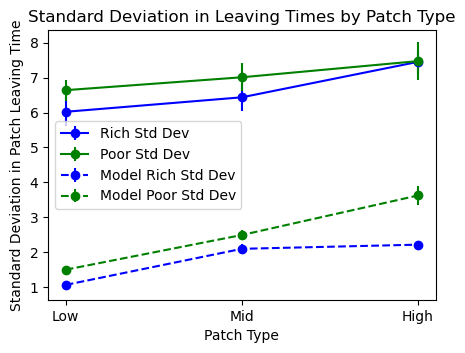

In [215]:
grouped = df_trials_with_simulation.groupby(['patch', 'env'])

std_observed = grouped['leaveT'].std().unstack()
std_simulated = grouped['simulated_leaveT'].std().unstack()

n_observed = grouped['leaveT'].count().unstack()
n_simulated = grouped['simulated_leaveT'].count().unstack()

sem_observed = std_observed / np.sqrt(n_observed)
sem_simulated = std_simulated / np.sqrt(n_simulated)

patch_types = ['Low', 'Mid', 'High']
patch_indices = np.arange(len(patch_types))

plt.figure(figsize=(5, 3.5))

plt.errorbar(patch_indices, std_observed[1], yerr=sem_observed[1], fmt='o-', color='blue', label='Rich Std Dev')
plt.errorbar(patch_indices, std_observed[2], yerr=sem_observed[2], fmt='o-', color='green', label='Poor Std Dev')

plt.errorbar(patch_indices, std_simulated[1], yerr=sem_simulated[1], fmt='--o', color='blue', label='Model Rich Std Dev')
plt.errorbar(patch_indices, std_simulated[2], yerr=sem_simulated[2], fmt='--o', color='green', label='Model Poor Std Dev')

plt.xticks(patch_indices, patch_types)
plt.xlabel('Patch Type')
plt.ylabel('Standard Deviation in Patch Leaving Time')
plt.title('Standard Deviation in Leaving Times by Patch Type')
plt.legend(loc='best')

plt.show()

### Standard deviation grouped per subject and visualized (Mean and Standard Error)

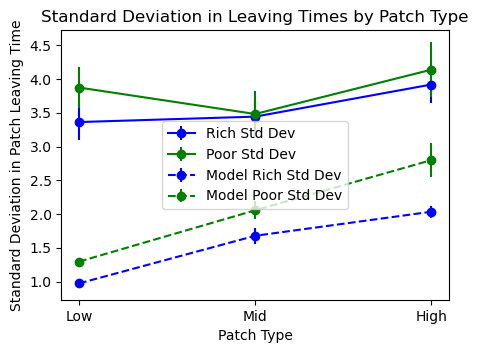

In [216]:
subject_grouped_observed = df_trials_with_simulation.groupby(['sub', 'patch', 'env'])['leaveT'].std().unstack(level=-1)
subject_grouped_simulated = df_trials_with_simulation.groupby(['sub', 'patch', 'env'])['simulated_leaveT'].std().unstack(level=-1)

mean_sd_observed = subject_grouped_observed.groupby('patch').mean()
sem_sd_observed = subject_grouped_observed.groupby('patch').sem()

mean_sd_simulated = subject_grouped_simulated.groupby('patch').mean()
sem_sd_simulated = subject_grouped_simulated.groupby('patch').sem()

patch_types = ['Low', 'Mid', 'High']
patch_indices = np.arange(len(patch_types))

plt.figure(figsize=(5, 3.5))

plt.errorbar(patch_indices, mean_sd_observed[1], yerr=sem_sd_observed[1], fmt='o-', color='blue', label='Rich Std Dev')
plt.errorbar(patch_indices, mean_sd_observed[2], yerr=sem_sd_observed[2], fmt='o-', color='green', label='Poor Std Dev')

plt.errorbar(patch_indices, mean_sd_simulated[1], yerr=sem_sd_simulated[1], fmt='--o', color='blue', label='Model Rich Std Dev')
plt.errorbar(patch_indices, mean_sd_simulated[2], yerr=sem_sd_simulated[2], fmt='--o', color='green', label='Model Poor Std Dev')

plt.xticks(patch_indices, patch_types)
plt.xlabel('Patch Type')
plt.ylabel('Standard Deviation in Patch Leaving Time')
plt.title('Standard Deviation in Leaving Times by Patch Type')
plt.legend(loc='best')

plt.show()

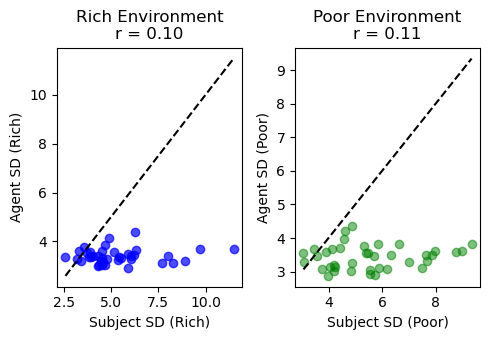

In [203]:
subject_sd_observed = df_trials_with_simulation.groupby(['sub', 'env'])['leaveT'].std().unstack()
subject_sd_simulated = df_trials_with_simulation.groupby(['sub', 'env'])['simulated_leaveT'].std().unstack()

rich_sd_observed = subject_sd_observed[1]
poor_sd_observed = subject_sd_observed[2]

rich_sd_simulated = subject_sd_simulated[1]
poor_sd_simulated = subject_sd_simulated[2]

corr_rich, _ = pearsonr(rich_sd_observed, rich_sd_simulated)
corr_poor, _ = pearsonr(poor_sd_observed, poor_sd_simulated)

plt.figure(figsize=(5, 3.5))

plt.subplot(1, 2, 1)
plt.scatter(rich_sd_observed, rich_sd_simulated, color='blue', alpha=0.7)
plt.plot([min(rich_sd_observed), max(rich_sd_observed)],
         [min(rich_sd_observed), max(rich_sd_observed)], 'k--')
plt.xlabel('Subject SD (Rich)')
plt.ylabel('Agent SD (Rich)')
plt.title(f'Rich Environment\nr = {corr_rich:.2f}')

plt.subplot(1, 2, 2)
plt.scatter(poor_sd_observed, poor_sd_simulated, color='green', alpha=0.5)
plt.plot([min(poor_sd_observed), max(poor_sd_observed)],
         [min(poor_sd_observed), max(poor_sd_observed)], 'k--')
plt.xlabel('Subject SD (Poor)')
plt.ylabel('Agent SD (Poor)')
plt.title(f'Poor Environment\nr = {corr_poor:.2f}')

plt.tight_layout()
plt.show()

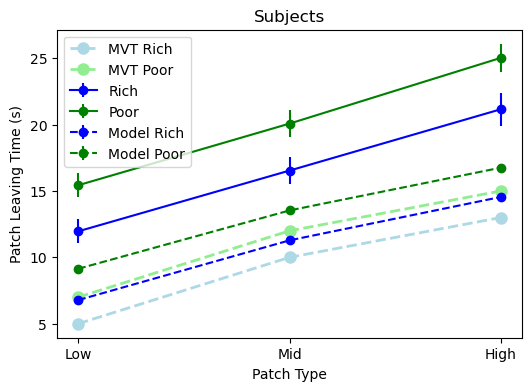

In [204]:
subject_grouped_observed = df_trials_with_simulation.groupby(['sub', 'patch', 'env'])['leaveT'].mean().unstack(level=-1)
subject_grouped_simulated = df_trials_with_simulation.groupby(['sub', 'patch', 'env'])['simulated_leaveT'].mean().unstack(level=-1)

mean_leave_observed = subject_grouped_observed.groupby('patch').mean()
sem_leave_observed = subject_grouped_observed.groupby('patch').sem()

mean_leave_simulated = subject_grouped_simulated.groupby('patch').mean()
sem_leave_simulated = subject_grouped_simulated.groupby('patch').sem()

patch_types = ['Low', 'Mid', 'High']
patch_indices = np.arange(len(patch_types))

plt.figure(figsize=(6, 4))

plt.errorbar(patch_indices, mean_leave_observed[1], yerr=sem_leave_observed[1], fmt='o-', color='blue', label='Rich')
plt.errorbar(patch_indices, mean_leave_observed[2], yerr=sem_leave_observed[2], fmt='o-', color='green', label='Poor')

plt.errorbar(patch_indices, mean_leave_simulated[1], yerr=sem_leave_simulated[1], fmt='--o', color='blue', label='Model Rich')
plt.errorbar(patch_indices, mean_leave_simulated[2], yerr=sem_leave_simulated[2], fmt='--o', color='green', label='Model Poor')

plt.plot(patch_indices, MVT_rich, 'o--', color='lightblue', label='MVT Rich', linewidth=2, markersize=8)
plt.plot(patch_indices, MVT_poor, 'o--', color='lightgreen', label='MVT Poor', linewidth=2, markersize=8)

plt.xticks(patch_indices, patch_types)
plt.xlabel('Patch Type')
plt.ylabel('Patch Leaving Time (s)')
plt.title('Subjects')
plt.legend(loc='best')

plt.show()

### Evolution of decay_rate_stds

In [4]:
from uncertainty_directed_exporation import Simulation
from utils import prepare_avg_rewards, decay_param_evolution, compare_variability_to_subject

In [7]:
subject_ids = df_trials['sub'].unique()
decay_rate_means = [0.075, 0.075, 0.075]
decay_rate_stds = [0.01, 0.01, 0.01]

avg_rewards = prepare_avg_rewards(df_trials, subject_ids, proportions, model)

simulation = Simulation(decay_rate_means=decay_rate_means, decay_rate_stds=decay_rate_stds, avg_rewards=avg_rewards, observation_var=0.00001, random_seed=123)
df_trials_with_simulation = simulation.run_simulation(df_trials)

agent_2, patch_sequence_2, _ = simulation.run_simulation(df_trials, subject_id=2)

In [5]:
def decay_param_evolution(agent):
    # Assuming agent_2 is the Agent instance from the simulation for Subject 2
    # Plot the trajectory of the mean and standard deviation of the decay rate for Subject 2
    fig, axes = plt.subplots(2, 3, figsize=(12, 5))

    patch_types = [1, 2, 3]
    patch_labels = ['Low', 'Mid', 'High']
    env_labels = {1: 'Rich', 2: 'Poor'}
    env_rows = {1: 0, 2: 1}  # Rich environment in the first row, Poor in the second row

    for patch_type in patch_types:
        for env in [1, 2]:
            mean_values = agent_2.mean_history[(patch_type, env)]
            std_values = agent_2.std_history[(patch_type, env)]
        
            if not mean_values:  # Check if the data exists
                print(f'No data for Patch {patch_type}, Environment {env}')
                continue
        
            ax = axes[env_rows[env], patch_type-1]  # Select the correct subplot

        # Time steps based on the length of the history
            time_steps = range(1, len(mean_values) + 1)
        
            ax.plot(time_steps, mean_values, label=f'{patch_labels[patch_type-1]} Patch {env_labels[env]} Mean', color='blue' if env == 1 else 'green')
            ax.fill_between(time_steps,
                        [mean - std for mean, std in zip(mean_values, std_values)],
                        [mean + std for mean, std in zip(mean_values, std_values)],
                        color='blue' if env == 1 else 'green', alpha=0.2)
        
            ax.set_title(f'{patch_labels[patch_type-1]} Patch ({env_labels[env]} Env)')
            ax.set_xlabel('Time Step')
            ax.set_ylabel('Decay Rate')
            ax.legend()

    plt.suptitle('Mean and SD of Decay Rate Trajectory for Subject 2', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

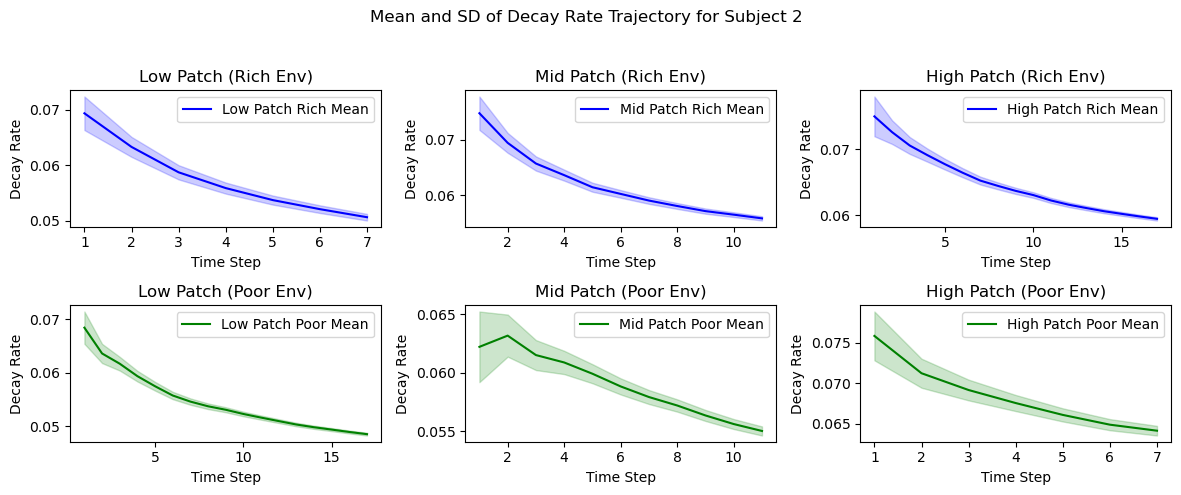

In [8]:
decay_param_evolution(agent_2)

In [9]:
def compare_variability_to_subject(df_trials_with_simulation):
    subject_grouped_observed = df_trials_with_simulation.groupby(['sub', 'patch', 'env'])['leaveT'].std().unstack(level=-1)
    subject_grouped_simulated = df_trials_with_simulation.groupby(['sub', 'patch', 'env'])['simulated_leaveT'].std().unstack(level=-1)

    mean_sd_observed = subject_grouped_observed.groupby('patch').mean()
    sem_sd_observed = subject_grouped_observed.groupby('patch').sem()

    mean_sd_simulated = subject_grouped_simulated.groupby('patch').mean()
    sem_sd_simulated = subject_grouped_simulated.groupby('patch').sem()

    patch_types = ['Low', 'Mid', 'High']
    patch_indices = np.arange(len(patch_types))

    plt.figure(figsize=(5, 3.5))

    plt.errorbar(patch_indices, mean_sd_observed[1], yerr=sem_sd_observed[1], fmt='o-', color='blue', label='Rich Std Dev')
    plt.errorbar(patch_indices, mean_sd_observed[2], yerr=sem_sd_observed[2], fmt='o-', color='green', label='Poor Std Dev')

    plt.errorbar(patch_indices, mean_sd_simulated[1], yerr=sem_sd_simulated[1], fmt='--o', color='blue', label='Model Rich Std Dev')
    plt.errorbar(patch_indices, mean_sd_simulated[2], yerr=sem_sd_simulated[2], fmt='--o', color='green', label='Model Poor Std Dev')

    plt.xticks(patch_indices, patch_types)
    plt.xlabel('Patch Type')
    plt.ylabel('Standard Deviation in Patch Leaving Time')
    plt.title('Standard Deviation in Leaving Times by Patch Type')
    plt.legend(loc='best')

    plt.show()

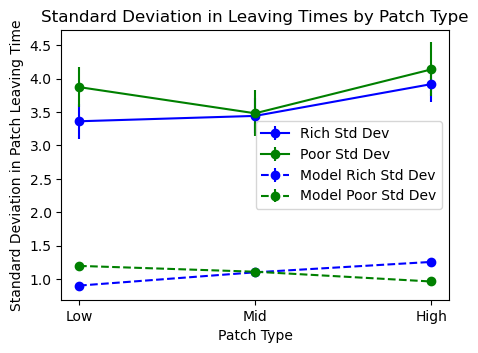

In [10]:
compare_variability_to_subject(df_trials_with_simulation)

### Comparing Methods

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
sys.path.append('../src')

from mvt_brr import MVTModel
from uncertainty_directed_exporation import Simulation
from utils import prepare_avg_rewards, decay_param_evolution, compare_variability_to_subject

model = MVTModel(decay_type='exponential')

In [2]:
df_trials = pd.read_csv("../leheron_trialbytrial/leheron_trialbytrial.csv")
# print(df_trials[:50])
proportions = df_trials.groupby(['sub', 'env', 'patch']).size().unstack(fill_value=0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)
proportions

patch           1         2         3
sub env                              
1   1    0.250000  0.250000  0.500000
    2    0.466667  0.333333  0.200000
2   1    0.200000  0.314286  0.485714
    2    0.485714  0.314286  0.200000
3   1    0.185185  0.259259  0.555556
...           ...       ...       ...
37  2    0.500000  0.291667  0.208333
38  1    0.185185  0.259259  0.555556
    2    0.500000  0.307692  0.192308
39  1    0.217391  0.260870  0.521739
    2    0.521739  0.304348  0.173913

[78 rows x 3 columns]

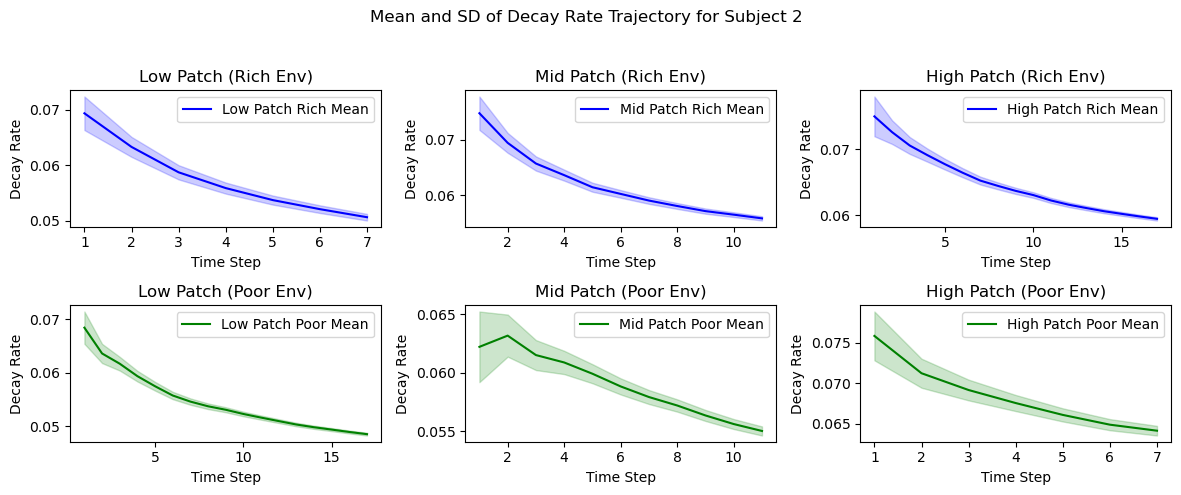

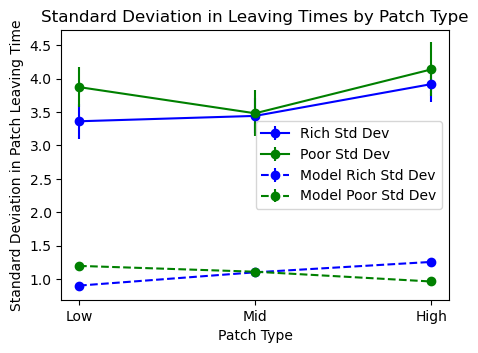

In [3]:
subject_ids = df_trials['sub'].unique()
decay_rate_means = [0.075, 0.075, 0.075]
decay_rate_stds = [0.01, 0.01, 0.01]

avg_rewards = prepare_avg_rewards(df_trials, subject_ids, proportions, model)

simulation = Simulation(decay_rate_means=decay_rate_means, decay_rate_stds=decay_rate_stds, avg_rewards=avg_rewards, observation_var=0.00001, method="bayesian", random_seed=123)
df_trials_with_simulation = simulation.run_simulation(df_trials)

agent_2, patch_sequence_2, _ = simulation.run_simulation(df_trials, subject_id=2)

decay_param_evolution(agent_2)

compare_variability_to_subject(df_trials_with_simulation)


### Rescorla-Wagner method based Agent

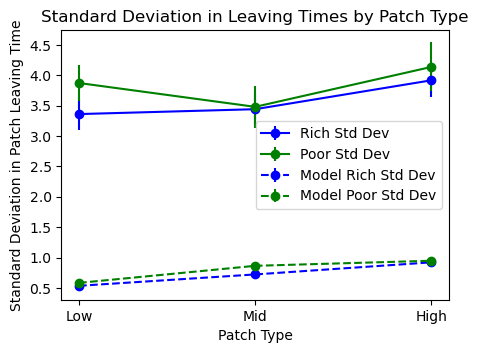

In [3]:
subject_ids = df_trials['sub'].unique()
decay_rate_means = [0.075, 0.075, 0.075]
decay_rate_stds = [0.005, 0.005, 0.005]

avg_rewards = prepare_avg_rewards(df_trials, subject_ids, proportions, model)

simulation = Simulation(
    decay_rate_means=decay_rate_means, 
    decay_rate_stds=decay_rate_stds, 
    avg_rewards=avg_rewards, 
    learning_rate=0.001, 
    method='rescorla_wagner', 
    random_seed=123)
df_trials_with_simulation = simulation.run_simulation(df_trials)

agent_2, patch_sequence_2, _ = simulation.run_simulation(df_trials, subject_id=2)

# decay_param_evolution(agent_2)

compare_variability_to_subject(df_trials_with_simulation)

Exponential Moving Average (EMA) based Stochastic Agent:

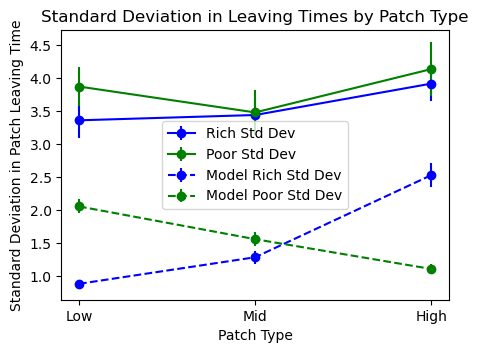

In [4]:
subject_ids = df_trials['sub'].unique()
decay_rate_means = [0.075, 0.075, 0.075]
decay_rate_stds = [0.005, 0.005, 0.005]

avg_rewards = prepare_avg_rewards(df_trials, subject_ids, proportions, model)

simulation = Simulation(
    decay_rate_means=decay_rate_means, 
    decay_rate_stds=decay_rate_stds, 
    avg_rewards=avg_rewards, 
    ema_alpha=0.5, 
    method='ema', 
    random_seed=123)
df_trials_with_simulation = simulation.run_simulation(df_trials)

agent_2, patch_sequence_2, _ = simulation.run_simulation(df_trials, subject_id=2)

# decay_param_evolution(agent_2)

compare_variability_to_subject(df_trials_with_simulation)

Fixed Noise

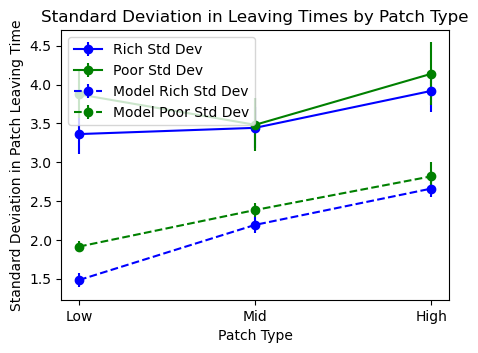

In [14]:
subject_ids = df_trials['sub'].unique()
decay_rate_means = [0.075, 0.075, 0.075]
decay_rate_stds = [0.01, 0.01, 0.01]

avg_rewards = prepare_avg_rewards(df_trials, subject_ids, proportions, model)

simulation = Simulation(
    decay_rate_means=decay_rate_means, 
    decay_rate_stds=decay_rate_stds, 
    avg_rewards=avg_rewards, 
    noise_std=0.2, 
    noise_decay_rate=0.99,
    method='fixed_noise', 
    random_seed=123)

df_trials_with_simulation = simulation.run_simulation(df_trials)

agent_2, patch_sequence_2, _ = simulation.run_simulation(df_trials, subject_id=2)

# decay_param_evolution(agent_2)

compare_variability_to_subject(df_trials_with_simulation)

Hierarchical Update Method

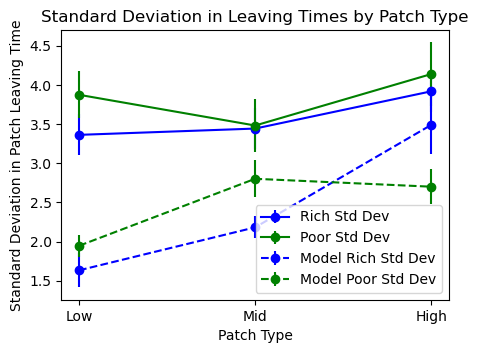

In [24]:
subject_ids = df_trials['sub'].unique()
decay_rate_means = [0.075, 0.075, 0.075]
decay_rate_stds = [0.015, 0.015, 0.015]

avg_rewards = prepare_avg_rewards(df_trials, subject_ids, proportions, model)

simulation = Simulation(
    decay_rate_means=decay_rate_means, 
    decay_rate_stds=decay_rate_stds, 
    avg_rewards=avg_rewards, 
    method='hierarchical', 
    random_seed=123)
df_trials_with_simulation = simulation.run_simulation(df_trials)

agent_2, patch_sequence_2, _ = simulation.run_simulation(df_trials, subject_id=2)

# decay_param_evolution(agent_2)

compare_variability_to_subject(df_trials_with_simulation)

no mean change

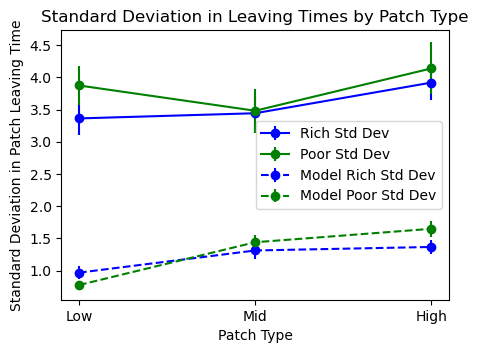

In [25]:
subject_ids = df_trials['sub'].unique()
decay_rate_means = [0.075, 0.075, 0.075]
decay_rate_stds = [0.015, 0.015, 0.015]

avg_rewards = prepare_avg_rewards(df_trials, subject_ids, proportions, model)

simulation = Simulation(
    decay_rate_means=decay_rate_means, 
    decay_rate_stds=decay_rate_stds, 
    avg_rewards=avg_rewards, 
    method='no_mean_change', 
    random_seed=123)
df_trials_with_simulation = simulation.run_simulation(df_trials)

agent_2, patch_sequence_2, _ = simulation.run_simulation(df_trials, subject_id=2)

# decay_param_evolution(agent_2)

compare_variability_to_subject(df_trials_with_simulation)